# Tugas Eksplorasi Pembelajaran Mendalam RB
## Reynaldi Cristian Simammora 122140116
## Perbandingan Model Vision Transformer B/16 dengan Swin Transformer Tiny pada Dataset CIFAR-10

In [ ]:
!pip install timm scikit-learn pandas matplotlib --quiet

In [ ]:
# Pemanggilan Library
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
import timm
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
# CIFAR-10 full class list
all_classes = [
    'airplane','automobile','bird','cat','deer',
    'dog','frog','horse','ship','truck'
]

# Choose 5 classes: bird, cat, deer, dog, frog
selected_names = ['bird','cat','deer','dog','frog']
selected_idx = [all_classes.index(c) for c in selected_names]
selected_idx


[2, 3, 4, 5, 6]

In [ ]:
# Preprocessing dataset dan augmentasi

class CIFAR5(Dataset):
    def __init__(self, train=True):
        self.base = torchvision.datasets.CIFAR10(
            root="./data",
            train=train,
            download=True
        )
        self.imgs = []
        self.labels = []

        for img, label in zip(self.base.data, self.base.targets):
            if label in selected_idx:
                self.imgs.append(img)
                # re-map labels to range 0..4
                self.labels.append(selected_idx.index(label))

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip() if train else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],
                                 [0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        img = self.transform(img)
        return img, label

train_full = CIFAR5(train=True)
test_ds = CIFAR5(train=False)

len(train_full), len(test_ds)


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


(25000, 5000)

In [ ]:
#split data train, dan test

val_ratio = 0.2
n = len(train_full)
n_val = int(n * val_ratio)
n_train = n - n_val

train_ds, val_ds = random_split(train_full, [n_train, n_val])

batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

n_train, n_val, len(test_ds)


(20000, 5000, 5000)

In [ ]:
# Pemanggilan model ViT B/16 DAN Swin-Tiny Transformer
from torchsummary import summary

print("===== ViT Base Patch16 Summary =====")
summary(model_vit, (3, 224, 224))

print("\n===== Swin-Tiny Summary =====")
summary(model_swin, (3, 224, 224))


===== ViT Base Patch16 Summary =====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
         Identity-11             [-1, 197, 768]               0
           Linear-12             [-1, 197, 768]         590,592
          Dropout-13             [-1, 197, 768]               0
  

In [ ]:
# ============================================================
# BLOCK — PARAMETER COUNT & MODEL SIZE
# ============================================================

def model_stats(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    # Estimasi ukuran model (float32 = 4 bytes)
    model_size_mb = (total_params * 4) / (1024**2)

    print(f"\n===== {model_name} — MODEL PARAMETERS =====")
    print(f"Total Parameters       : {total_params:,}")
    print(f"Trainable Parameters   : {trainable_params:,}")
    print(f"Non-Trainable Params   : {non_trainable_params:,}")
    print(f"Approx Model Size (MB) : {model_size_mb:.2f} MB")
    print("-" * 50)

# For ViT and Swin
model_stats(model_vit, "ViT-B/16")
model_stats(model_swin, "Swin-Tiny")



===== ViT-B/16 — MODEL PARAMETERS =====
Total Parameters       : 85,802,501
Trainable Parameters   : 85,802,501
Non-Trainable Params   : 0
Approx Model Size (MB) : 327.31 MB
--------------------------------------------------

===== Swin-Tiny — MODEL PARAMETERS =====
Total Parameters       : 27,523,199
Trainable Parameters   : 27,523,199
Non-Trainable Params   : 0
Approx Model Size (MB) : 104.99 MB
--------------------------------------------------


In [ ]:
## Fungsi Matematis training
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        running_loss += loss.item() * labels.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss/total, correct/total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    preds_all = []
    labels_all = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(1)

        running_loss += loss.item() * labels.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    return (running_loss/total, correct/total, np.array(preds_all), np.array(labels_all))


In [ ]:
## Fungsi menjalankan training untuk masing masing model dengan konfigurasi parameter

def run_experiment(model_name, num_epochs=5, lr=1e-4):
    print(f"\n🚀 Training {model_name}")

    model = timm.create_model(model_name, pretrained=True, num_classes=5)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_acc = 0
    best_model = None

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, num_epochs+1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, history


In [ ]:
EPOCHS = 5

model_vit, hist_vit = run_experiment("vit_base_patch16_224", num_epochs=EPOCHS)
model_swin, hist_swin = run_experiment("swin_tiny_patch4_window7_224", num_epochs=EPOCHS)



🚀 Training vit_base_patch16_224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Epoch 1/5


Train Acc: 0.9046 | Val Acc: 0.9344

Epoch 2/5


Train Acc: 0.9462 | Val Acc: 0.9128

Epoch 3/5


Train Acc: 0.9595 | Val Acc: 0.9194

Epoch 4/5


Train Acc: 0.9609 | Val Acc: 0.9210

Epoch 5/5


Train Acc: 0.9688 | Val Acc: 0.9358

🚀 Training swin_tiny_patch4_window7_224


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Epoch 1/5


Train Acc: 0.9111 | Val Acc: 0.9386

Epoch 2/5


Train Acc: 0.9575 | Val Acc: 0.9582

Epoch 3/5


Train Acc: 0.9710 | Val Acc: 0.9442

Epoch 4/5


Train Acc: 0.9753 | Val Acc: 0.9488

Epoch 5/5


Train Acc: 0.9798 | Val Acc: 0.9506


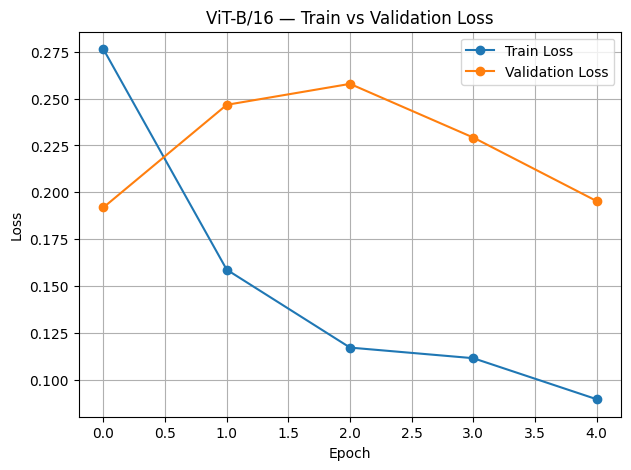

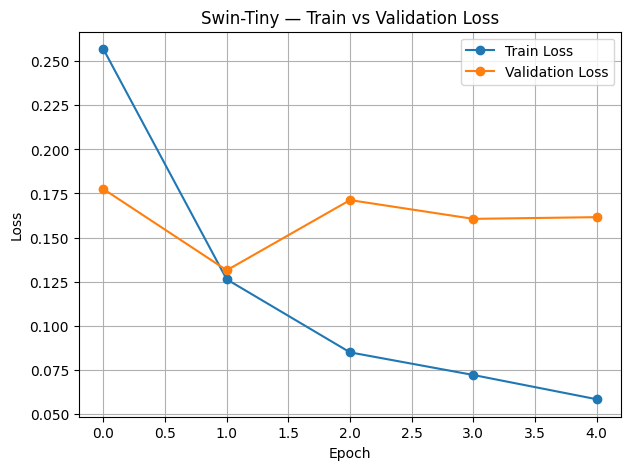

In [ ]:
# ================================================
# BLOCK — Kurva Plot Train & Validation Loss
# ================================================

def plot_loss(history, title):
    plt.figure(figsize=(7,5))
    plt.plot(history["train_loss"], label="Train Loss", marker='o')
    plt.plot(history["val_loss"], label="Validation Loss", marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot for ViT-B/16
plot_loss(hist_vit, "ViT-B/16 — Train vs Validation Loss")

# Plot for Swin-Tiny
plot_loss(hist_swin, "Swin-Tiny — Train vs Validation Loss")


📌 Testing ViT-B/16
Test Accuracy: 0.9322

Classification Report:
              precision    recall  f1-score   support

        bird       0.98      0.94      0.96      1000
         cat       0.85      0.92      0.89      1000
        deer       0.93      0.99      0.96      1000
         dog       0.92      0.91      0.91      1000
        frog       0.99      0.91      0.95      1000

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



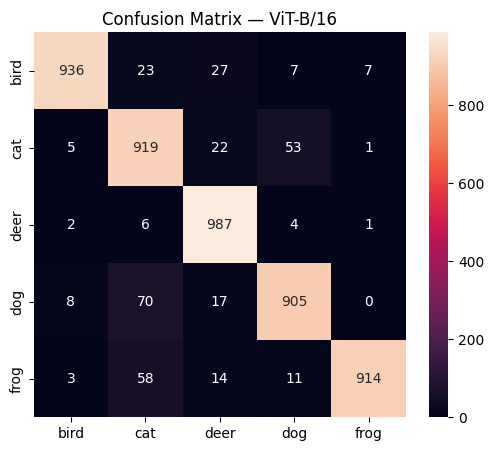


📌 Testing Swin-T
Test Accuracy: 0.9442

Classification Report:
              precision    recall  f1-score   support

        bird       0.98      0.95      0.96      1000
         cat       0.92      0.91      0.91      1000
        deer       0.90      0.99      0.94      1000
         dog       0.95      0.92      0.94      1000
        frog       0.97      0.96      0.97      1000

    accuracy                           0.94      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.95      0.94      0.94      5000



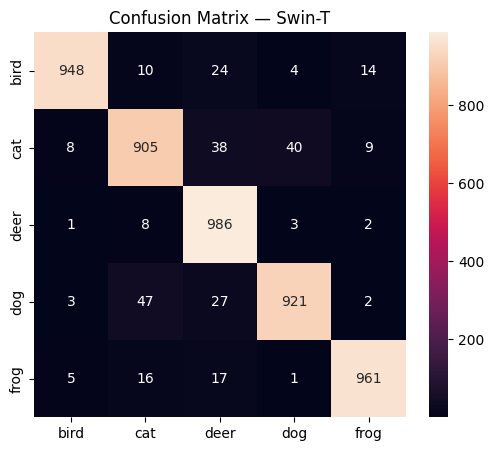

In [ ]:
## Fungsi pengujian model dengan data testing
def test_model(model, name):
    print(f"\n📌 Testing {name}")
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=selected_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=selected_names, yticklabels=selected_names)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

    return test_acc, y_true, y_pred

test_vit_acc, _, _ = test_model(model_vit, "ViT-B/16")
test_swin_acc, _, _ = test_model(model_swin, "Swin-T")


In [ ]:
comparison = pd.DataFrame({
    "Model": ["ViT-B/16", "Swin-Tiny"],
    "Test Accuracy": [test_vit_acc, test_swin_acc],
    "Params (M)": [
        sum(p.numel() for p in model_vit.parameters())/1e6,
        sum(p.numel() for p in model_swin.parameters())/1e6
    ]
})

comparison


,Model,Test Accuracy,Params (M)
0,ViT-B/16,0.9322,85.802501
1,Swin-Tiny,0.9442,27.523199


In [ ]:
# ================================
# 📦 BLOCK — Save Fine-Tuned Models
# ================================

vit_path  = "vit_finetuned_5class.pth"
swin_path = "swin_finetuned_5class.pth"

torch.save(model_vit.state_dict(), vit_path)
torch.save(model_swin.state_dict(), swin_path)

print("Model berhasil disimpan:")
print(f"- ViT disimpan di: {vit_path}")
print(f"- Swin disimpan di: {swin_path}")


Model berhasil disimpan:
- ViT disimpan di: vit_finetuned_5class.pth
- Swin disimpan di: swin_finetuned_5class.pth


🔍 Random Inference — ViT


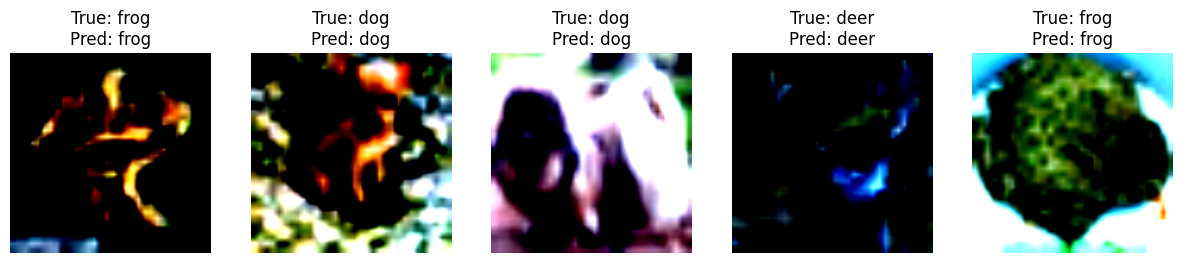

🔍 Random Inference — Swin


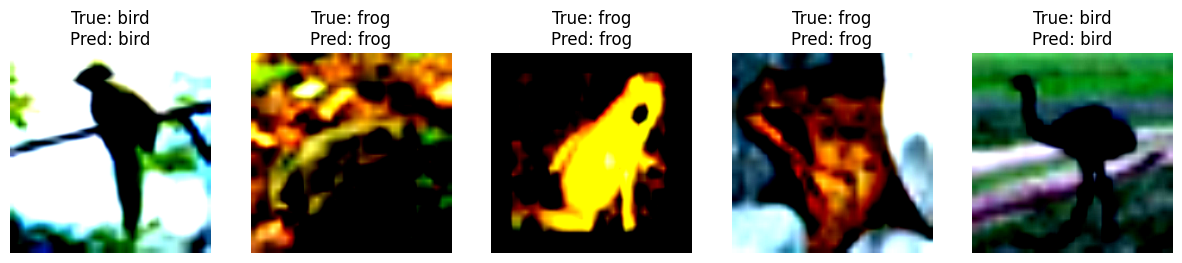

In [ ]:
import random

def random_inference(model, n=5):
    model.eval()
    indices = random.sample(range(len(test_ds)), n)

    plt.figure(figsize=(15,4))
    for i, idx in enumerate(indices):
        img, label = test_ds[idx]
        img_batch = img.unsqueeze(0).to(device)
        pred = model(img_batch).argmax(1).item()

        plt.subplot(1, n, i+1)
        plt.imshow(img.permute(1,2,0).cpu().numpy())
        plt.title(f"True: {selected_names[label]}\nPred: {selected_names[pred]}")
        plt.axis("off")

    plt.show()

print("🔍 Random Inference — ViT")
random_inference(model_vit)

print("🔍 Random Inference — Swin")
random_inference(model_swin)


In [ ]:
## Menghubungkan colabs dengan folder drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================================================
# IMPORT LIBRARY DAN DATASET DARI DRIVE
# ================================================
import os
import torch
import timm
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

infer_folder = "/content/drive/MyDrive/inferences_data"

selected_names = ["bird", "cat", "deer", "dog", "frog"]
class_to_idx = {name: i for i, name in enumerate(selected_names)}

# ================================================
# 3. Memuat Model yang telah dihasilkan dari drive
# ================================================
device = "cuda" if torch.cuda.is_available() else "cpu"

model_vit = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=5)
model_vit.load_state_dict(torch.load("/content/drive/MyDrive/save_models/vit_finetuned_5class.pth", map_location=device))
model_vit.to(device).eval()

model_swin = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=5)
model_swin.load_state_dict(torch.load("/content/drive/MyDrive/save_models/swin_finetuned_5class.pth", map_location=device))
model_swin.to(device).eval()

# ================================================
# 4. Proses Augmentasi Transform Inferensi
# ================================================
inference_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])



In [ ]:
# ================================================
# 5. Pemetaan folder inferensi data
# ================================================
def inference_from_folder(model, folder_path):
    results = []

    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue

        true_label = class_to_idx.get(label_name)
        if true_label is None:
            continue

        for img_name in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_name)

            try:
                img = Image.open(img_path).convert("RGB")
            except:
                continue

            img_tensor = inference_transform(img).unsqueeze(0).to(device)
            pred = model(img_tensor).argmax(1).item()

            results.append([img_name, label_name, selected_names[pred]])

    return pd.DataFrame(results, columns=["filename", "true_label", "pred_label"])


In [ ]:
# ================================================
# 6.Menjalankan proses pengujian dengan data inferensi
# ================================================
df_vit = inference_from_folder(model_vit, infer_folder)
df_swin = inference_from_folder(model_swin, infer_folder)

df_vit.head(), df_swin.head()


(  filename true_label pred_label
 0  004.jpg       bird       bird
 1  003.jpg       bird       bird
 2  006.jpg       bird       bird
 3  131.jpg       bird       bird
 4  025.jpg       bird       bird,
   filename true_label pred_label
 0  004.jpg       bird       bird
 1  003.jpg       bird       bird
 2  006.jpg       bird       bird
 3  131.jpg       bird       bird
 4  025.jpg       bird       bird)

===== HASIL INFERENSI — ViT Base Patch16 =====
              precision    recall  f1-score   support

        bird       0.83      0.95      0.88        20
         cat       0.71      1.00      0.83        20
        deer       0.83      1.00      0.91        20
         dog       1.00      0.70      0.82        20
        frog       1.00      0.55      0.71        20

    accuracy                           0.84       100
   macro avg       0.87      0.84      0.83       100
weighted avg       0.87      0.84      0.83       100



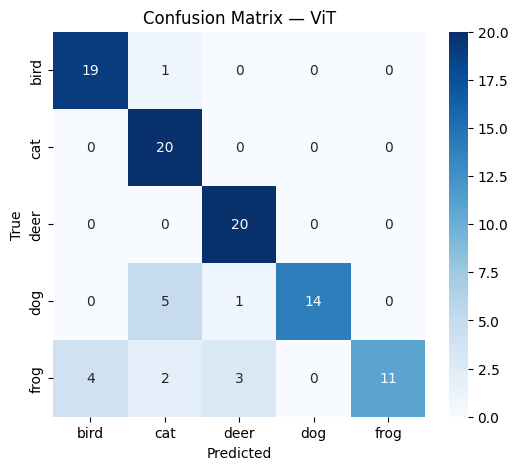

===== HASIL INFERENSI — Swin Tiny =====
              precision    recall  f1-score   support

        bird       0.87      1.00      0.93        20
         cat       0.79      0.95      0.86        20
        deer       0.80      1.00      0.89        20
         dog       0.94      0.75      0.83        20
        frog       1.00      0.60      0.75        20

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.85       100
weighted avg       0.88      0.86      0.85       100



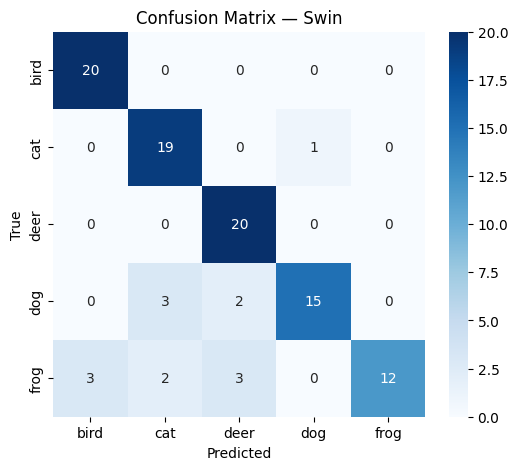

In [ ]:
# ================================================
# 7. Visualisasi dengan matrix confusion
# ================================================
def show_confusion(df, title):
    cm = confusion_matrix(df.true_label, df.pred_label, labels=selected_names)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=selected_names,
                yticklabels=selected_names,
                cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("===== HASIL INFERENSI — ViT Base Patch16 =====")
print(classification_report(df_vit.true_label, df_vit.pred_label, labels=selected_names, target_names=selected_names))
show_confusion(df_vit, "Confusion Matrix — ViT")

print("===== HASIL INFERENSI — Swin Tiny =====")
print(classification_report(df_swin.true_label, df_swin.pred_label, labels=selected_names, target_names=selected_names))
show_confusion(df_swin, "Confusion Matrix — Swin")


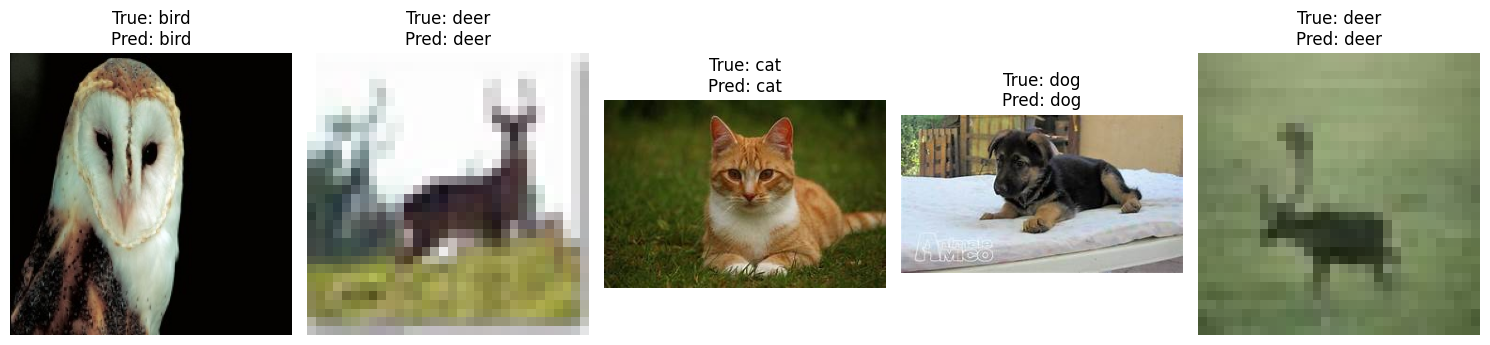

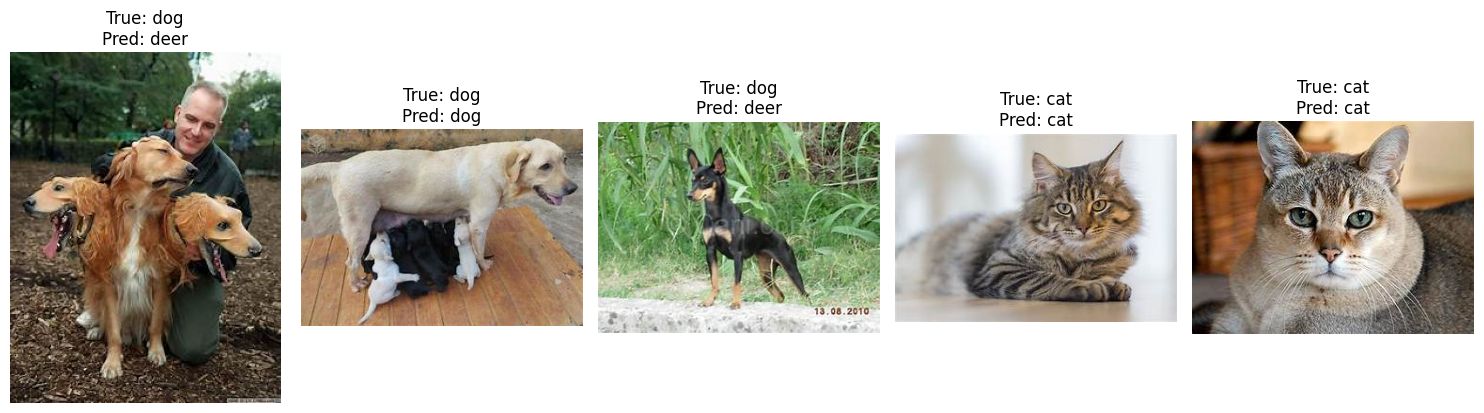

In [ ]:
# ================================================
# 8. VISUALISASI DENGAN GAMBAR RANDOM INFERENSI
# ================================================
def visualize_random(df, folder, n=5):
    samples = df.sample(n)
    plt.figure(figsize=(15, 4))

    for idx, row in enumerate(samples.itertuples(), 1):
        img_path = os.path.join(folder, row.true_label, row.filename)
        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, n, idx)
        plt.imshow(img)
        plt.title(f"True: {row.true_label}\nPred: {row.pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_random(df_vit, infer_folder, n=5)
visualize_random(df_swin, infer_folder, n=5)


In [ ]:
# ============================================================
# Analisa waktu inferensi
# ============================================================

import time
import numpy as np

def measure_inference_time(model, folder, n_repeat=50):
    model.eval()
    samples = []

    # collect 50 random images from test folder
    for label in os.listdir(folder):
        path_cat = os.path.join(folder, label)
        if not os.path.isdir(path_cat): continue

        for fname in os.listdir(path_cat):
            samples.append(os.path.join(path_cat, fname))

    samples = samples[:n_repeat]  # limit for speed

    timings = []
    for img_path in samples:
        img = Image.open(img_path).convert("RGB")
        tensor = inference_transform(img).unsqueeze(0).to(device)

        start = time.time()
        _ = model(tensor)
        end = time.time()

        timings.append((end - start) * 1000)  # milliseconds

    avg_ms = np.mean(timings)
    total_time = np.sum(timings)
    throughput = len(samples) / (total_time / 1000)

    return avg_ms, total_time, throughput

vit_avg, vit_total, vit_tp = measure_inference_time(model_vit, infer_folder)
swin_avg, swin_total, swin_tp = measure_inference_time(model_swin, infer_folder)

print("\n===== INFERENCE SPEED (ViT-B/16) =====")
print(f"Avg Latency per Image : {vit_avg:.3f} ms")
print(f"Total Time            : {vit_total:.3f} ms")
print(f"Throughput            : {vit_tp:.3f} images/sec")

print("\n===== INFERENCE SPEED (Swin-Tiny) =====")
print(f"Avg Latency per Image : {swin_avg:.3f} ms")
print(f"Total Time            : {swin_total:.3f} ms")
print(f"Throughput            : {swin_tp:.3f} images/sec")



===== INFERENCE SPEED (ViT-B/16) =====
Avg Latency per Image : 24.955 ms
Total Time            : 1247.725 ms
Throughput            : 40.073 images/sec

===== INFERENCE SPEED (Swin-Tiny) =====
Avg Latency per Image : 25.704 ms
Total Time            : 1285.215 ms
Throughput            : 38.904 images/sec


In [ ]:
# ============================================================
# Informasi Perangkat yang digunakan dalam menjalankan notebook eksperimen
# ============================================================

import torch
import platform

print("\n===== HARDWARE INFO =====")

print("System:", platform.system(), platform.release())
print("CPU:", platform.processor())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("GPU: None (CPU Only)")



===== HARDWARE INFO =====
System: Linux 6.6.105+
CPU: x86_64
GPU: Tesla T4
CUDA Version: 12.6
